In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import datetime as dt
import pprint as pp
import pandas as pd
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_pickle('../data/player_game_table.pkl')
df2 = pd.read_pickle('./player_vs_table_3.pkl')

features = ['ast','blk','min', 'ftm','fg3m', 'fgm', 'pts','reb','stl','to','fantasy_points']
matchup_features = ['ast','blk','min', 'ftm', 'fg3m', 'fgm', 'pts','reb','stl','tov', 'fantasy_points']

In [ ]:
def create_input_features(pid, n, df, feats):
    seasons = ["2016-2017","2017-2018"]
    
    rows = df.loc[ (df['player_id'] == pid) & (df['season'].isin(seasons))]
    rows = rows.sort_values("game_date")

    X = np.zeros(( (len(rows) - (n), (len(feats)*n)+len(matchup_features)*(n+1))))
    y = np.zeros((len(rows) - (n)))
    for i in range(n+1, (len(rows) - 1)):
        last_n = rows.iloc[((i-1) - (n)) : i-1]
        #X[(i - n),0] = pid

        for a,feat in enumerate(feats):
            start_idx = a*n
            end_idx = start_idx + n
            X[(i - n),start_idx:end_idx] = last_n[feat].tolist()
            
        for b,mufeat in enumerate(matchup_features):
            #Calculate matchup statistics
            for j in range (0, n+1):
                
                fp_opp = []
                min_opp = []
                current_game = df.iloc[i].game_id
                pids = df.loc[df.game_id == current_game].player_id
                for pid in pids:
                    if rows.iloc[i-j].season == "2016-2017":
                        x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2015-16')]
                    else:
                        x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2016-17')]
                    if len(x)>0:
                        fp_opp.append(x[mufeat].values[0])
                        min_opp

                feature_average = np.average(fp_opp)
                X[(i-n), len(feats)*n+(b*(n+1)+j)] = feature_average

        y[i-(n)] = rows.iloc[i]["fantasy_points"]
        
    return X, y

In [42]:
def create_input_features_average(pid, df, feats):
    seasons = ["2016-2017","2017-2018"]
    
    rows = df.loc[ (df['player_id'] == pid) & (df['season'].isin(seasons))]
    rows = rows.sort_values("game_date")

    X = np.zeros((len(rows) -1, (len(feats))+len(matchup_features)))
    y = np.zeros(len(rows) -1 )
    for i in range(1, (len(rows) - 1)):
        average_rows = rows.loc[(rows.game_date<rows.iloc[i].game_date) & (rows.season == rows.iloc[i].season)]
        #X[(i - n),0] = pid

        if len(average_rows) > 0:
            for a,feat in enumerate(feats):
                X[i,a] = np.average(average_rows[feat].tolist())

            for b,mufeat in enumerate(matchup_features):
                #Calculate matchup statistics
                current_game = df.iloc[i].game_id
                pids = df.loc[df.game_id == current_game].player_id
                for pid in pids:
                    
                    fp_opp = []
                    min_opp = []
                    if rows.iloc[i].season == "2016-2017":
                        x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2015-16')]
                    else:
                        x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2016-17')]
                    if len(x)>0:
                        fp_opp.append(x[mufeat].values[0])

                    if (len(fp_opp) > 0):
                        feature_average = np.average(fp_opp)
                        X[i, len(feats)+(b)] = feature_average

            y[i] = rows.iloc[i]["fantasy_points"]
        
    return X, y

In [31]:
def create_input_features(pid, n, df, feats):
    seasons = ["2016-2017","2017-2018"]
    
    rows = df.loc[ (df['player_id'] == pid) & (df['season'].isin(seasons))]
    rows = rows.sort_values("game_date")

    X = np.zeros(( (len(rows) - (n), len(matchup_features))))
    y = np.zeros((len(rows) - (n)))
    for i in range(n, (len(rows) - 1)):
        last_n = rows.iloc[(i - n) : i]
        #X[(i - n),0] = pid
        fp_opp = []
        min_opp = []

        for b,mufeat in enumerate(matchup_features):
            #Calculate matchup statistics
            current_game = df.iloc[i].game_id
            pids = df.loc[df.game_id == current_game].player_id
            for pid in pids:
                if rows.iloc[i].season == "2016-2017":
                    x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2015-16')]
                else:
                    x = df2.loc[(df2.player_id =='2544') & (df2.player_vs_id == pid) & (df2.season == '2016-17')]
                if len(x)>0 & x["min"].values[0] > 0:
                    fp_opp.append(x[mufeat].values[0])
                    min_opp.append(x["min"].values[0])

            feature_average = np.ma.average(fp_opp, weights=min_opp)
            X[(i-n), b] = feature_average

        y[i-(n)] = rows.iloc[i]["fantasy_points"]
        
    return X, y

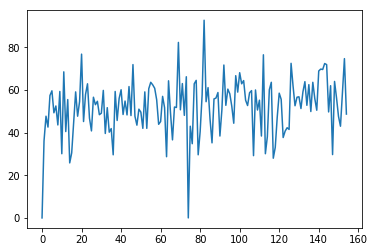

In [43]:
X, y = create_input_features_average('2544', df, features)
lebron_dict = {}
lebron_dict["X"] = X
lebron_dict["y"] = y

with open('lebron_2018.pkl', 'wb') as fp:
    pickle.dump(lebron_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)


plt.plot([i for i in range(len(y))],y)
plt.show()

In [ ]:
with open('lebron_2018.pkl', 'rb') as fp:
    lebron = pickle.load(fp)
    


X = lebron["X"]
y = lebron["y"]



In [44]:
scaler = StandardScaler()
X = scaler.fit_transform(X,y)
#X = X[:-1]
#y = y[:-1]
X = X[1:]
y = y[1:]
print(np.shape(X))


(154, 22)


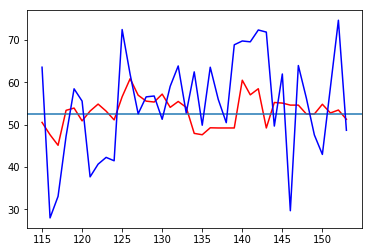

0.07376157538412087


In [45]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=20, random_state=0,n_estimators=10,criterion = 'mae',n_jobs =8,max_features=10)
train_split = 3/4
train_n = int(len(y)*train_split)
regr.fit(X[:train_n],y[:train_n])

plt.plot(list(range(train_n,len(y))),regr.predict(X[train_n:]),'r')
plt.axhline(y = np.average(y))
plt.plot(list(range(train_n,len(y))),y[train_n:],'b')
plt.show()
print(regr.score(X[train_n:],y[train_n:]))